In [102]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

DATA PREPARATION

In [103]:
data = pd.read_csv('all_anime_clean.csv')

In [104]:
data

,Unnamed: 0,anime_id,user_id,Name,Tags,watching_status,watched_episodes,rating
0,12,1061,1,Heroic Age,"Action, Adventure, Mecha, Sci Fi, Aliens, Mili...",5,1,2.5
1,28,2375,1,Mazinger Edition Z: The Impact!,"Action, Mecha, Sci Fi, Super Robot",3,1,2.0
2,36,2764,1,Chu-Bra!!,"Comedy, Ecchi, Seinen, Panty Shots, School Lif...",5,6,2.0
3,41,4683,1,Fate/Zero 2,"Action, Fantasy, Contemporary Fantasy, Magic, ...",2,11,4.5
4,43,1333,1,Sky Girls TV,"Sci Fi, Slice of Life, Military, Post-apocalyp...",2,6,3.0
...,...,...,...,...,...,...,...,...
811855,20842079,8988,79300,Hakata Tonkotsu Ramens,"Mystery, Assassins, Criminals, Detectives, Gan...",3,1,3.5
811856,20842099,8894,79300,Katana Maidens: Toji no Miko,"Action, Monsters, School Life, Supernatural, S...",3,2,3.0
811857,20842113,8312,79300,Boruto: Naruto Next Generations,"Action, Fantasy, Shounen, Ninja, Based on a Manga",2,113,4.5
811858,20842165,9540,79300,Today's Menu for Emiya Family,"Slice of Life, Cooking, Food and Beverage, Rec...",3,6,2.5


COLLABORATIVE FILTERING

In [105]:
data = data.drop(['Unnamed: 0'], axis=1)

In [106]:
data

,anime_id,user_id,Name,Tags,watching_status,watched_episodes,rating
0,1061,1,Heroic Age,"Action, Adventure, Mecha, Sci Fi, Aliens, Mili...",5,1,2.5
1,2375,1,Mazinger Edition Z: The Impact!,"Action, Mecha, Sci Fi, Super Robot",3,1,2.0
2,2764,1,Chu-Bra!!,"Comedy, Ecchi, Seinen, Panty Shots, School Lif...",5,6,2.0
3,4683,1,Fate/Zero 2,"Action, Fantasy, Contemporary Fantasy, Magic, ...",2,11,4.5
4,1333,1,Sky Girls TV,"Sci Fi, Slice of Life, Military, Post-apocalyp...",2,6,3.0
...,...,...,...,...,...,...,...
811855,8988,79300,Hakata Tonkotsu Ramens,"Mystery, Assassins, Criminals, Detectives, Gan...",3,1,3.5
811856,8894,79300,Katana Maidens: Toji no Miko,"Action, Monsters, School Life, Supernatural, S...",3,2,3.0
811857,8312,79300,Boruto: Naruto Next Generations,"Action, Fantasy, Shounen, Ninja, Based on a Manga",2,113,4.5
811858,9540,79300,Today's Menu for Emiya Family,"Slice of Life, Cooking, Food and Beverage, Rec...",3,6,2.5


In [107]:
user_ids = data['user_id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
data['user'] = data['user_id'].map(user_to_user_encoded)

In [108]:
anime_ids = data['anime_id'].unique().tolist()
anime_to_anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded_to_anime = {i: x for i, x in enumerate(anime_ids)}
data['anime'] = data['anime_id'].map(anime_to_anime_encoded)

In [109]:
num_users = len(user_to_user_encoded)
num_animes = len(anime_encoded_to_anime)
min_rating = min(data['rating'])
max_rating = max(data['rating'])
print('Number of users: {}, Number of animes: {}, Min rating: {}, Max rating: {}'.format(num_users, num_animes, min_rating, max_rating))

Number of users: 53581, Number of animes: 7933, Min rating: 0.5, Max rating: 5.0


DATA SPLIT

In [110]:
data = data.sample(frac=1, random_state=30)
data

,anime_id,user_id,Name,Tags,watching_status,watched_episodes,rating,user,anime
487471,14362,47953,Fire Force 2nd Season,"Action, Comedy, Ecchi, Shounen, Elemental Powe...",2,23,3.5,32288,1001
555145,7896,54287,Strike the Blood II,"Action, Fantasy, Harem, Demons, Island, Magic,...",5,1,3.0,36617,1505
171622,1082,16761,IGPX: Immortal Grand Prix,"Action, Mecha, Sci Fi, Sports, Racing, Origina...",5,13,2.5,11268,3582
501509,1286,49291,Strawberry Panic,"GL, Romance, Shoujo-ai, All-Girls School, Boar...",3,6,2.0,33185,1684
244520,13739,24046,Attack on Titan The Final Season,"Action, Drama, Fantasy, Horror, Shounen, Dark ...",2,7,4.5,16194,337
...,...,...,...,...,...,...,...,...,...
496379,74,48749,One Piece,"Action, Adventure, Comedy, Fantasy, Shounen, P...",2,906,4.0,32834,29
328599,3693,32267,Blue Exorcist,"Action, Fantasy, Shounen, Contemporary Fantasy...",3,4,3.0,21748,449
570508,1131,55637,Naruto Shippuden,"Action, Drama, Fantasy, Shounen, Hand to Hand ...",2,375,4.5,37514,43
572333,1512,55807,Clannad,"Comedy, Drama, Harem, Romance, Delinquents, Ro...",2,9,4.0,37629,31


In [111]:
x = data[['user', 'anime']].values
y = data['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
train_indices = int(0.8 * data.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
print(x, y)
print(x.shape)
print(y.shape)
print(x_val.shape)
print(y_val.shape)

[[32288  1001]
 [36617  1505]
 [11268  3582]
 ...
 [37514    43]
 [37629    31]
 [28742  1351]] [0.66666667 0.55555556 0.44444444 ... 0.88888889 0.77777778 0.66666667]
(811860, 2)
(811860,)
(162372, 2)
(162372,)


MODELLING

In [112]:
class RecommenderNet(tf.keras.Model):

  def __init__(self, num_users, num_animes, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_animes = num_animes
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.anime_embedding = layers.Embedding(
        num_animes,
        embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=keras.regularizers.l2(1e-6)
    )
    self.anime_bias = layers.Embedding(num_animes, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:, 0])
    user_bias = self.user_bias(inputs[:, 0])
    anime_vector = self.anime_embedding(inputs[:, 1])
    anime_bias = self.anime_bias(inputs[:, 1])
    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2)
    x = dot_user_anime + user_bias + anime_bias
    return tf.nn.sigmoid(x)

In [113]:
model = RecommenderNet(num_users, num_animes, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

In [114]:
hist = model.fit(x = x_train, y = y_train, batch_size = 8, epochs = 20, validation_data = (x_val, y_val))

Epoch 1/20
81186/81186 [==============================] - 2071s 25ms/step - loss: 0.6304 - root_mean_squared_error: 0.2328 - val_loss: 0.6155 - val_root_mean_squared_error: 0.2170
Epoch 2/20
81186/81186 [==============================] - 2054s 25ms/step - loss: 0.6079 - root_mean_squared_error: 0.2099 - val_loss: 0.6082 - val_root_mean_squared_error: 0.2100
Epoch 3/20
81186/81186 [==============================] - 2073s 26ms/step - loss: 0.6011 - root_mean_squared_error: 0.2032 - val_loss: 0.6047 - val_root_mean_squared_error: 0.2066
Epoch 4/20
81186/81186 [==============================] - 1988s 24ms/step - loss: 0.5976 - root_mean_squared_error: 0.1998 - val_loss: 0.6035 - val_root_mean_squared_error: 0.2055
Epoch 5/20
81186/81186 [==============================] - 1996s 25ms/step - loss: 0.5955 - root_mean_squared_error: 0.1976 - val_loss: 0.6030 - val_root_mean_squared_error: 0.2050
Epoch 6/20
81186/81186 [==============================] - 1997s 25ms/step - loss: 0.5940 - root_mean

RMSE : Metrics Visualization

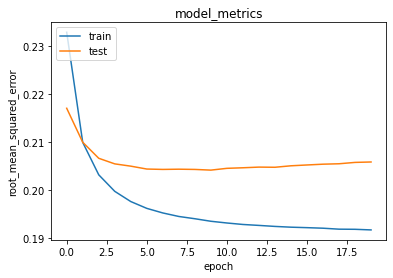

In [115]:
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

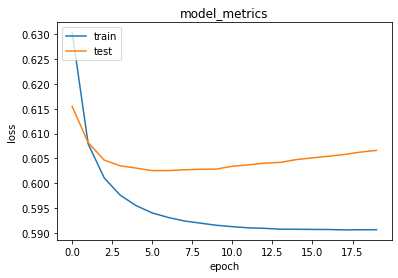

In [116]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model_metrics')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [163]:
anime_recommend = pd.DataFrame({
    'anime_id' : data.anime_id,
    'anime_genre' : data.Tags,
    'anime_name' : data.Name
})
anime_recommend

,anime_id,anime_genre,anime_name
487471,14362,"Action, Comedy, Ecchi, Shounen, Elemental Powe...",Fire Force 2nd Season
555145,7896,"Action, Fantasy, Harem, Demons, Island, Magic,...",Strike the Blood II
171622,1082,"Action, Mecha, Sci Fi, Sports, Racing, Origina...",IGPX: Immortal Grand Prix
501509,1286,"GL, Romance, Shoujo-ai, All-Girls School, Boar...",Strawberry Panic
244520,13739,"Action, Drama, Fantasy, Horror, Shounen, Dark ...",Attack on Titan The Final Season
...,...,...,...
496379,74,"Action, Adventure, Comedy, Fantasy, Shounen, P...",One Piece
328599,3693,"Action, Fantasy, Shounen, Contemporary Fantasy...",Blue Exorcist
570508,1131,"Action, Drama, Fantasy, Shounen, Hand to Hand ...",Naruto Shippuden
572333,1512,"Comedy, Drama, Harem, Romance, Delinquents, Ro...",Clannad


In [164]:
animes_rcm = anime_recommend
rcm = pd.read_csv('all_anime_clean.csv')

rcm['rating'] = rcm['rating'].values.astype(np.float32)

user_id = rcm.user_id.sample(1).iloc[0]
animes_watched_by_user = rcm[rcm.user_id == user_id]

animes_not_watched = animes_rcm[~animes_rcm['anime_id'].isin(animes_watched_by_user.anime_id.values)]['anime_id']
animes_not_watched = list(
    set(animes_not_watched)
    .intersection(set(anime_to_anime_encoded.keys()))
)

animes_not_watched = [[anime_to_anime_encoded.get(x)] for x in animes_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_animes_array = np.hstack(
    ([[user_encoder]] * len(animes_not_watched), animes_not_watched)
)

In [168]:
ratings = model.predict(user_animes_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_animes_ids = [anime_encoded_to_anime.get(animes_not_watched[x][0]) for x in top_ratings_indices]

print('Showing recommendations for users : {}'.format(user_id))
print('===' * 10)

print('Anime with high ratings from user')
print('----' * 10)

top_animes_user = (
    animes_watched_by_user.sort_values(
        by='rating',
        ascending=False
    )
    .head(5)
    .anime_id.values
)

top_animes_user_df = anime_recommend[anime_recommend['anime_id'].isin(top_animes_user)]
top_animes_user_df = top_animes_user_df.drop_duplicates(subset=['anime_name'])
for row in top_animes_user_df.itertuples():
    print(row.anime_name, ':', row.anime_genre)

print('----' * 10)
print('Top 10 anime recommendations')
print('----' * 10)

recommended_animes = animes_rcm[animes_rcm['anime_id'].isin(recommended_animes_ids)]
recommended_animes = recommended_animes.drop_duplicates(subset=['anime_name'])
for row in recommended_animes.itertuples():
    print(row.anime_name, ':', row.anime_genre)

248/248 [==============================] - 1s 5ms/step
Showing recommendations for users : 48841
Anime with high ratings from user
----------------------------------------
Hunter x Hunter (2011) : Action, Adventure, Drama, Fantasy, Shounen, Monsters, Superpowers, Based on a Manga
My Hero Academia 5 : Action, Sci Fi, Shounen, Superheroes, Based on a Manga
Fairy Tail : Action, Adventure, Comedy, Drama, Fantasy, Shounen, Elemental Powers, Guilds, Magic, Based on a Manga
I’ve Been Killing Slimes for 300 Years and Maxed Out My Level : Comedy, Fantasy, Slice of Life, Isekai, Magic, Overpowered Main Characters, Person in a Strange World, Reincarnation, RPG, Slimes, Slow Life, Witches, Based on a Light Novel
How NOT to Summon a Demon Lord: Omega : Action, Comedy, Ecchi, Fantasy, Shounen, Demon King, Demons, Isekai, Magic, Overpowered Main Characters, Person in a Strange World, RPG, Summoned Into Another World, Trapped in a Video Game, Based on a Light Novel
------------------------------------

In [171]:
data_filtered = data[data['user_id'] == 48841]
data_filtered

,anime_id,user_id,Name,Tags,watching_status,watched_episodes,rating,user,anime
497036,14843,48841,How NOT to Summon a Demon Lord: Omega,"Action, Comedy, Ecchi, Fantasy, Shounen, Demon...",2,9,4.0,32885,686
497037,16049,48841,Full Dive: This Ultimate Next-Gen Full Dive RP...,"Action, Comedy, Fantasy, MMORPG, RPG, Virtual ...",3,7,1.5,32885,226
497043,4336,48841,Hunter x Hunter (2011),"Action, Adventure, Drama, Fantasy, Shounen, Mo...",2,52,5.0,32885,28
497040,14132,48841,I’ve Been Killing Slimes for 300 Years and Max...,"Comedy, Fantasy, Slice of Life, Isekai, Magic,...",2,10,5.0,32885,229
497039,2703,48841,Fairy Tail,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",2,130,5.0,32885,30
497045,14420,48841,To Your Eternity,"Adventure, Drama, Fantasy, Shounen, Animal Tra...",2,10,4.0,32885,616
497044,14666,48841,The Slime Diaries: That Time I Got Reincarnate...,"Adventure, Comedy, Fantasy, Shounen, Slice of ...",2,8,3.5,32885,1274
497041,7516,48841,Magi: Adventure of Sinbad,"Action, Adventure, Comedy, Fantasy, Shounen, A...",3,3,1.0,32885,835
497042,14827,48841,My Hero Academia 5,"Action, Sci Fi, Shounen, Superheroes, Based on...",2,12,5.0,32885,218
497038,12179,48841,Cautious Hero: The Hero Is Overpowered but Ove...,"Action, Adventure, Comedy, Fantasy, Demons, Go...",3,2,0.5,32885,613
